## Tomato-Disease-Detection-Using CNN

##### Dataset_Source-Kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
! kaggle datasets download -d arjuntejaswi/plant-village

100% 328M/329M [00:10<00:00, 35.6MB/s]
100% 329M/329M [00:10<00:00, 33.3MB/s]


In [4]:
import zipfile
ref=zipfile.ZipFile('/content/plant-village.zip')
ref.extractall()
ref.close()

In [8]:
! rmdir /content/PlantVillage/.ipynb_checkpoints

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt

1. Calling "image_dataset_from_directory" will return a tf.data.Dataset that yields batches of images from the subdirectories

2. This will split images into batches otherwise there might be a chance of crash if the img_data set is too large

In [25]:
im_data=tf.keras.utils.image_dataset_from_directory(
    '/content/PlantVillage',
    image_size=(128,128),
    batch_size=32,
    shuffle=True
)

Found 16011 files belonging to 10 classes.


In [32]:
class_names=im_data.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [27]:
type(im_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

In [29]:
l=len(im_data)
l

501

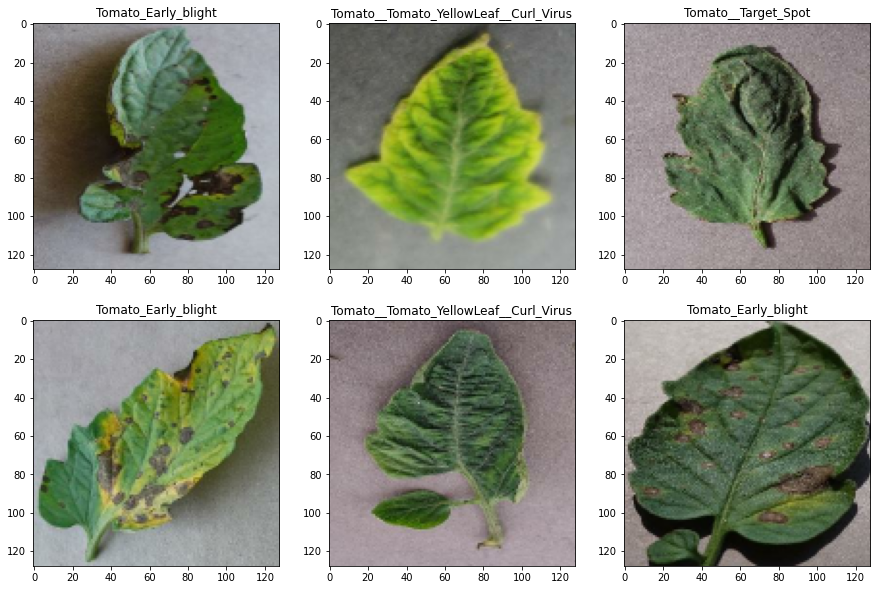

In [38]:
plt.figure(figsize=(15,10))
for img,lab in im_data.take(1):
  for i in range(6):
      plt.subplot(2,3,i+1)
      plt.title(class_names[lab[i]])
      plt.imshow(img[i].numpy().astype('uint8'))


**Train_test_validation_spliting**

In [43]:
def train_test_val_split(data,train_s=0.8,val_s=0.1,test_s=0.1,shuffle=True,shuffle_size=1000):

         d_s=len(data)

         train_size=int(d_s*train_s)
         test_size=int(d_s*test_s)

         train_ds=im_data.take(train_size)
         test_ds=im_data.skip(train_size).take(test_size)
         val_ds=im_data.skip(train_size).skip(test_size)

         return train_ds,test_ds,val_ds



In [44]:
train_ds,test_ds,val_ds=train_test_val_split(im_data)

In [45]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

400
50
51


In [46]:
scale_n_resize=tf.keras.Sequential([
    keras.layers.experimental.preprocessing.Resizing(128,128),
    keras.layers.experimental.preprocessing.Rescaling(1/255)
])

**Data augmentation to avoid overfitting**

In [16]:
data_augmentation=keras.Sequential(
    [keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    keras.layers.experimental.preprocessing.RandomRotation(0.3)]
)

**CNN -- Model creation**

In [17]:
model = keras.models.Sequential([
    scale_n_resize,
    data_augmentation,
    
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=(32,128,128,3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(64,activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.build(input_shape=(32,128,128,3))

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

**Model Training**

In [22]:
cnn_tr=model.fit(train_ds,batch_size=32,validation_data=val_ds,verbose=1,epochs=15)

Epoch 1/15
400/400 [==============================] - 56s 113ms/step - loss: 0.2709 - accuracy: 0.9045 - val_loss: 0.2362 - val_accuracy: 0.9044
Epoch 2/15
400/400 [==============================] - 55s 111ms/step - loss: 0.2651 - accuracy: 0.9083 - val_loss: 0.2673 - val_accuracy: 0.9025
Epoch 3/15
400/400 [==============================] - 55s 111ms/step - loss: 0.2453 - accuracy: 0.9149 - val_loss: 0.2375 - val_accuracy: 0.9094
Epoch 4/15
400/400 [==============================] - 55s 112ms/step - loss: 0.2514 - accuracy: 0.9132 - val_loss: 0.1993 - val_accuracy: 0.9256
Epoch 5/15
400/400 [==============================] - 55s 111ms/step - loss: 0.2388 - accuracy: 0.9184 - val_loss: 0.2571 - val_accuracy: 0.9050
Epoch 6/15
400/400 [==============================] - 55s 111ms/step - loss: 0.2049 - accuracy: 0.9291 - val_loss: 0.2717 - val_accuracy: 0.9050
Epoch 7/15
400/400 [==============================] - 54s 111ms/step - loss: 0.2052 - accuracy: 0.9289 - val_loss: 0.1596 - val_ac

In [51]:
acc=cnn_tr.history['accuracy']
acc

[0.9044526219367981,
 0.9082870483398438,
 0.9149385690689087,
 0.9132170081138611,
 0.9183816909790039,
 0.9291024208068848,
 0.9288676977157593,
 0.9275781512260437,
 0.9329368472099304,
 0.9366406202316284,
 0.9450660943984985,
 0.9475702047348022,
 0.9416229724884033,
 0.9418577551841736,
 0.9472572207450867]

In [52]:
loss=cnn_tr.history['loss']
loss

[0.27088624238967896,
 0.26512813568115234,
 0.24530571699142456,
 0.25143906474113464,
 0.2388342320919037,
 0.20491604506969452,
 0.20515580475330353,
 0.2067285031080246,
 0.18737511336803436,
 0.17911657691001892,
 0.16296836733818054,
 0.15602029860019684,
 0.16457517445087433,
 0.17077240347862244,
 0.14745144546031952]

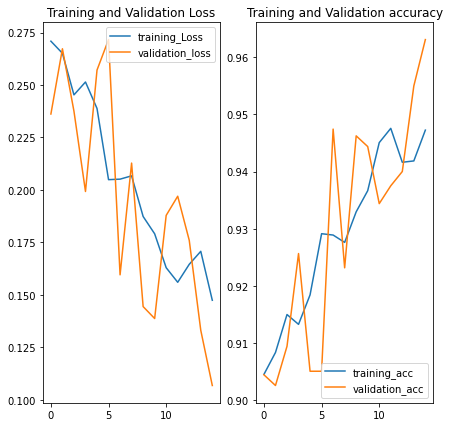

In [60]:
plt.figure(figsize=(7,7));
plt.subplot(1,2,1);
plt.title('Training and Validation Loss');
plt.plot(range(15),loss,label='training_Loss');
plt.plot(range(15),cnn_tr.history['val_loss'],label='validation_loss');
plt.legend(loc='upper right');

plt.subplot(1,2,2);
plt.title('Training and Validation accuracy');
plt.plot(range(15),acc,label='training_acc');
plt.plot(range(15),cnn_tr.history['val_accuracy'],label='validation_acc');
plt.legend(loc='lower right');

**Model testing using unseen data**

In [61]:
model.evaluate(test_ds)  

50/50 [==============================] - 11s 30ms/step - loss: 0.1050 - accuracy: 0.9619


[0.10495349019765854, 0.9618750214576721]

**Plotting model predictions**

1/1 [==============================] - 0s 17ms/step


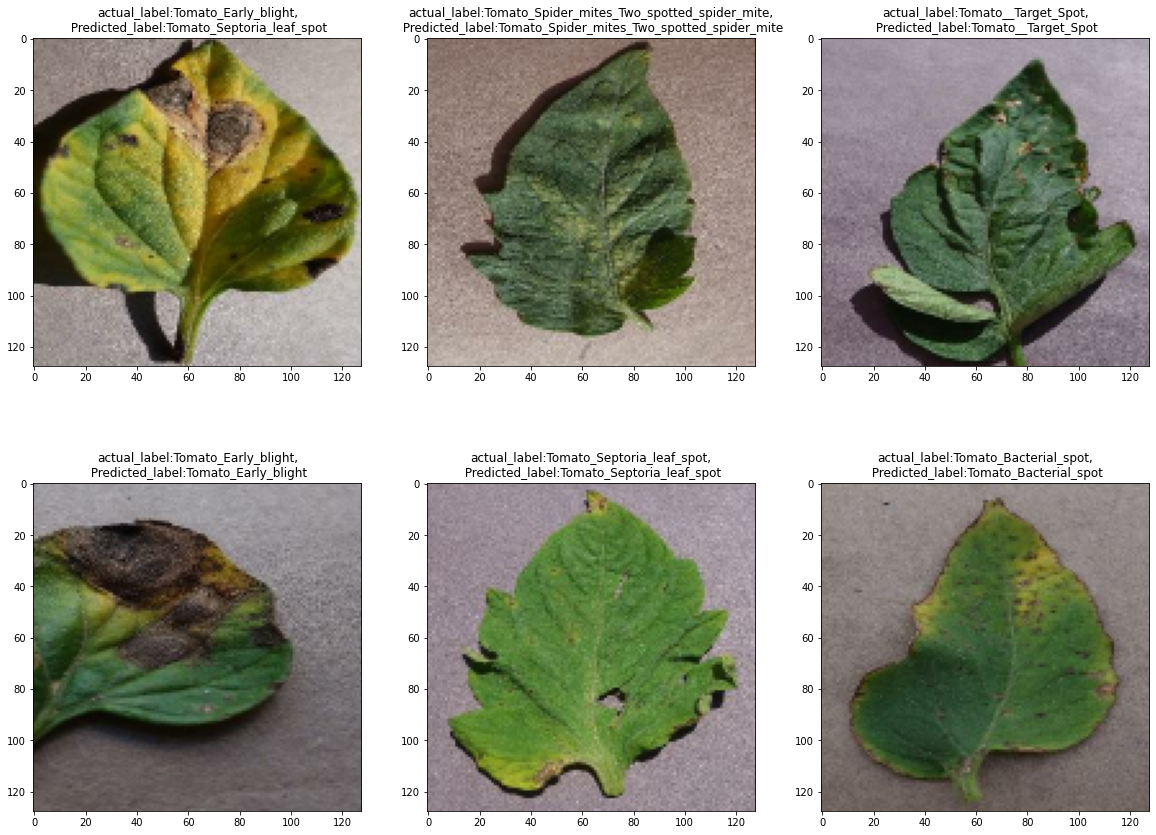

In [67]:
import numpy as np
plt.figure(figsize=(20,15))
for img,lab in test_ds.take(1):
      for i in range(6):
        plt.subplot(2,3,i+1)
        img_mod=tf.expand_dims(img[i].numpy(),0)
        a_l=class_names[lab[i]]
        pred=model.predict(img_mod)
        pred=class_names[np.argmax(pred)]
        plt.title(f'actual_label:{a_l},\n Predicted_label:{pred}')
        plt.imshow(img[i].numpy().astype('uint8'))
